# EDA for five datasets

## Import the Libraries

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load a datasets

In [57]:
df_patients = pd.read_csv('/content/patients.csv')
df_admissions = pd.read_csv('/content/admissions.csv')
df_items = pd.read_csv("/content/d_items.csv")
df_chartevents = pd.read_csv("/content/chartevents.csv")

## Basic EDA for patients.csv

In [32]:
# 1. Unique Patients
n_rows = len(df_patients)
n_unique_patients = df_patients['subject_id'].nunique()
is_unique = df_patients['subject_id'].is_unique

print("Total rows:", n_rows)
print("Unique patients:", n_unique_patients)
print("Is subject_id unique?", is_unique)

Total rows: 100
Unique patients: 100
Is subject_id unique? True


In [33]:
# 2. Gender Distribution
print("\nGender distribution:")
print(df_patients['gender'].value_counts(dropna=False))


Gender distribution:
gender
M    57
F    43
Name: count, dtype: int64


In [34]:
# 3. Anchor Age
print("\nAnchor age summary:")
print(df_patients['anchor_age'].describe())

# Flag unrealistic ages (<0 or >120)
unrealistic_age = df_patients[(df_patients['anchor_age'] < 0) | (df_patients['anchor_age'] > 120)]
print("\nUnrealistic ages found:", len(unrealistic_age))


Anchor age summary:
count    100.00000
mean      61.75000
std       16.16979
min       21.00000
25%       51.75000
50%       63.00000
75%       72.00000
max       91.00000
Name: anchor_age, dtype: float64

Unrealistic ages found: 0


In [35]:
# 4. Anchor Year
print("\nAnchor year summary:")
print(df_patients['anchor_year'].describe())


Anchor year summary:
count     100.000000
mean     2148.680000
std        25.629008
min      2110.000000
25%      2129.000000
50%      2145.500000
75%      2172.500000
max      2201.000000
Name: anchor_year, dtype: float64


In [36]:
# 5. Death Dates (dod)
dod_count = df_patients['dod'].notna().sum()
print("\nPatients with death date:", dod_count)

# Quick check: earliest and latest dod
print("Death date range:")
print(df_patients['dod'].dropna().min(), "to", df_patients['dod'].dropna().max())


Patients with death date: 31
Death date range:
2111-11-15 to 2201-12-24


patients (1) ───▶ (many) admissions
         │
         └──▶ (many) ICU stays
         └──▶ (many) lab events

## Check Missing Values in patients

In [37]:
# Missingness counts
missing_gender = df_patients['gender'].isna().sum()
missing_dob = df_patients['dob'].isna().sum() if 'dob' in df_patients.columns else "dob not in dataset"
missing_dod = df_patients['dod'].isna().sum()

print("Missing gender:", missing_gender)
print("Missing dod:", missing_dod)

Missing gender: 0
Missing dod: 69


## Basic EDA for admissions.csv

In [38]:
# Admissions per patient
df_admissions.groupby('subject_id')['hadm_id'].nunique().describe()

,hadm_id
count,100.0000
mean,2.7500
std,3.1794
min,1.0000
25%,1.0000
50%,1.0000
75%,3.0000
max,20.0000


In [39]:
# Compute duration in days/hours
df_admissions['admittime'] = pd.to_datetime(df_admissions['admittime'])
df_admissions['dischtime'] = pd.to_datetime(df_admissions['dischtime'])
df_admissions['duration_days'] = (df_admissions['dischtime'] - df_admissions['admittime']).dt.days

In [43]:
# Explore distribution
df_admissions['duration_days'].describe()

,duration_days
count,275.000000
mean,6.327273
std,6.745246
min,0.000000
25%,2.000000
50%,4.000000
75%,8.000000
max,44.000000


<Axes: >

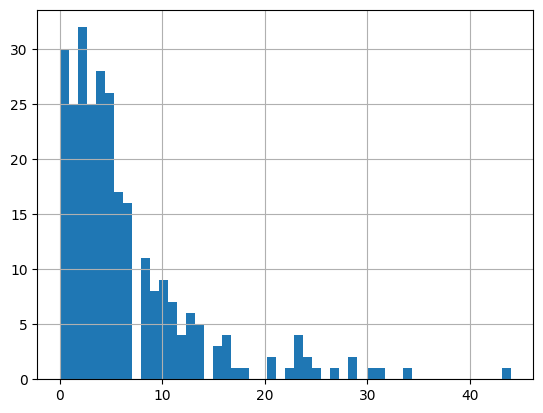

In [42]:
df_admissions['duration_days'].hist(bins=50)

In [44]:
# Frequency of admission types
df_admissions['admission_type'].value_counts(normalize=True)

,proportion
admission_type,
EW EMER.,0.378182
OBSERVATION ADMIT,0.163636
URGENT,0.138182
EU OBSERVATION,0.109091
SURGICAL SAME DAY ADMISSION,0.065455
DIRECT EMER.,0.054545
ELECTIVE,0.047273
DIRECT OBSERVATION,0.025455
AMBULATORY OBSERVATION,0.018182


In [45]:
# Ratio of Emergency vs Elective
emergency_ratio = (df_admissions['admission_type'] == 'EW EMER.').mean()
elective_ratio = (df_admissions['admission_type'] == 'ELECTIVE').mean()

In [46]:
# Check payer mix
df_admissions['insurance'].value_counts(normalize=True)

,proportion
insurance,
Other,0.541818
Medicare,0.378182
Medicaid,0.080000


In [47]:
# Mortality flag:
df_admissions['hospital_expire_flag'].value_counts(normalize=True)

,proportion
hospital_expire_flag,
0,0.945455
1,0.054545


In [48]:
# Cross-tab with admission type
pd.crosstab(df_admissions['admission_type'], df_admissions['hospital_expire_flag'])

hospital_expire_flag,0,1
admission_type,,
AMBULATORY OBSERVATION,5,0
DIRECT EMER.,14,1
DIRECT OBSERVATION,7,0
ELECTIVE,13,0
EU OBSERVATION,30,0
EW EMER.,98,6
OBSERVATION ADMIT,42,3
SURGICAL SAME DAY ADMISSION,18,0
URGENT,33,5


## Missing Values & Data Quality

In [49]:
# --- Missingness checks ---
missing_summary = {
    "admittime_missing": df_admissions['admittime'].isna().sum(),
    "dischtime_missing": df_admissions['dischtime'].isna().sum(),
    "admission_type_missing": df_admissions['admission_type'].isna().sum(),
    "diagnosis_missing": df_admissions['diagnosis'].isna().sum() if 'diagnosis' in df_admissions.columns else "diagnosis not in dataset",
    "outcome_flag_missing": df_admissions['hospital_expire_flag'].isna().sum() if 'hospital_expire_flag' in df_admissions.columns else "flag not in dataset"
}

print("=== Missingness Summary ===")
for k, v in missing_summary.items():
    print(f"{k}: {v}")

=== Missingness Summary ===
admittime_missing: 0
dischtime_missing: 0
admission_type_missing: 0
diagnosis_missing: diagnosis not in dataset
outcome_flag_missing: 0


In [50]:
# --- Sanity checks ---
# Convert to datetime
df_admissions['admittime'] = pd.to_datetime(df_admissions['admittime'], errors='coerce')
df_admissions['dischtime'] = pd.to_datetime(df_admissions['dischtime'], errors='coerce')

# Discharge before admission
invalid_discharge = df_admissions[df_admissions['dischtime'] < df_admissions['admittime']]
print(f"\nInvalid discharge before admission: {len(invalid_discharge)} rows")

# Length of stay calculation
df_admissions['los_days'] = (df_admissions['dischtime'] - df_admissions['admittime']).dt.days
invalid_los = df_admissions[df_admissions['los_days'] <= 0]
print(f"Zero or negative length of stay: {len(invalid_los)} rows")


Invalid discharge before admission: 0 rows
Zero or negative length of stay: 30 rows


## Basic EDA for d_items.csv

In [54]:
# --- Unique itemids ---
unique_itemids = df_items['itemid'].nunique()
print(f"Unique itemids: {unique_itemids}")

# --- How many belong to chartevents ---
chartevents_count = (df_items['linksto'] == 'chartevents').sum()
print(f"Itemids linked to chartevents: {chartevents_count}")

# --- Categories ---
categories = df_items['category'].value_counts()
print("\nCategory distribution:")
print(categories)

# --- Unit consistency ---
unit_consistency = df_items.groupby('label')['unitname'].nunique().sort_values(ascending=False)
print("\nUnit consistency check (labels with >1 unit):")
print(unit_consistency[unit_consistency > 1])

Unique itemids: 4014
Itemids linked to chartevents: 2982

Category distribution:
category
Skin - Impairment           412
Access Lines - Invasive     363
Respiratory                 163
Labs                        161
Medications                 137
                           ... 
Case Management               2
2-Ventilation                 2
ApacheIV Parameters           2
RNTriggerNote                 1
Research Enrollment Note      1
Name: count, Length: 81, dtype: int64

Unit consistency check (labels with >1 unit):
label
Aminocaproic acid (Amicar)    2
Angiotensin II (Giapreza)     2
Name: unitname, dtype: int64


In [55]:
# --- Identify candidate ICU vitals ---
# Filter only chartevents-linked items
chartevents_items = df_items[df_items['linksto'] == 'chartevents']

In [56]:

# Separate numeric vs categorical vs irrelevant
numeric_candidates = chartevents_items[chartevents_items['unitname'].notna()]
categorical_candidates = chartevents_items[chartevents_items['unitname'].isna()]
irrelevant_items = df_items[df_items['linksto'] != 'chartevents']

print("=== Candidate ICU Vitals (numeric time-series) ===")
print(numeric_candidates[['itemid','label','unitname','category']].head(20))

print("\n=== Categorical candidates (non-numeric signals) ===")
print(categorical_candidates[['itemid','label','category']].head(20))

print("\n=== Irrelevant items (not from chartevents) ===")
print(irrelevant_items[['itemid','label','linksto']].head(20))

# Final count of candidate ICU vitals
print(f"\nTotal candidate ICU vitals: {numeric_candidates['itemid'].nunique()}")

=== Candidate ICU Vitals (numeric time-series) ===
      itemid                    label unitname category
1878  229842                Flow (CH)    L/min     ECMO
1879  229280              FiO2 (ECMO)        %     ECMO
1881  229277             Speed (ECMO)      RPM     ECMO
1882  229365           P1 - P2 (ECMO)     mmHg     ECMO
1883  229841                FiO2 (CH)        %     ECMO
1885  229363                P1 (ECMO)     mmHg     ECMO
1887  229364                P2 (ECMO)     mmHg     ECMO
1891  229270              Flow (ECMO)    L/min     ECMO
1894  229845               Speed (CH)      RPM     ECMO
1897  224654                    PAEDP     mmHg     IABP
1898  224317           ABI Ankle BP R     mmHg     IABP
1899  224322                IABP Mean     mmHg     IABP
1900  224652       Unassisted Systole     mmHg     IABP
1901  228866  Plateau Pressure (IABP)     mmHg     IABP
1902  224310       Augmented Diastole     mmHg     IABP
1903  228146        ABI Brachial BP R     mmHg     IA

## EDA for ChartEvents

In [58]:
# --- Scale ---
total_rows = len(df_chartevents)
unique_hadm = df_chartevents['hadm_id'].nunique()
unique_itemid = df_chartevents['itemid'].nunique()

print(f"Total rows: {total_rows}")
print(f"Unique admissions (hadm_id): {unique_hadm}")
print(f"Unique itemids: {unique_itemid}")

Total rows: 668862
Unique admissions (hadm_id): 128
Unique itemids: 1318


In [59]:
# --- Measurement density ---
rows_per_admission = df_chartevents.groupby('hadm_id').size().describe()
rows_per_itemid = df_chartevents.groupby('itemid').size().describe()

print("\nMeasurements per admission (distribution):")
print(rows_per_admission)

print("\nMeasurements per itemid (distribution):")
print(rows_per_itemid)


Measurements per admission (distribution):
count      128.000000
mean      5225.484375
std       6735.598518
min        245.000000
25%       1303.000000
50%       2607.000000
75%       5476.250000
max      37061.000000
dtype: float64

Measurements per itemid (distribution):
count     1318.000000
mean       507.482549
std       1301.999874
min          1.000000
25%         17.000000
50%         71.000000
75%        428.750000
max      19330.000000
dtype: float64


In [60]:
# --- Map itemid → label ---
df_chartevents = df_chartevents.merge(
    df_items[['itemid','label','category','unitname']],
    on='itemid',
    how='left'
)
# Inspect mapped columns
print(df_chartevents[['subject_id','hadm_id','charttime','itemid','label','valuenum','unitname']].head(10))

   subject_id   hadm_id            charttime  itemid  \
0    10005817  20626031  2132-12-16 00:00:00  225054   
1    10005817  20626031  2132-12-16 00:00:00  223769   
2    10005817  20626031  2132-12-16 00:00:00  223956   
3    10005817  20626031  2132-12-16 00:00:00  224866   
4    10005817  20626031  2132-12-16 00:00:00  227341   
5    10005817  20626031  2132-12-16 00:00:00  224751   
6    10005817  20626031  2132-12-16 00:00:00  227969   
7    10005817  20626031  2132-12-16 00:00:00  223935   
8    10005817  20626031  2132-12-16 00:00:00  223782   
9    10005817  20626031  2132-12-16 00:00:00  224773   

                                      label  valuenum unitname  
0                Anti Embolic Device Status       NaN      NaN  
1  O2 Saturation Pulseoxymetry Alarm - High     100.0        %  
2                  Temporary Pacemaker Mode       NaN      NaN  
3                  Temporary Atrial Capture       NaN      NaN  
4       History of falling (within 3 mnths)       0.0     

### Identify IMPORTANT ICU VITALS

In [61]:
# Define core ICU vitals by label keywords
core_vitals = ["Heart Rate", "Respiratory Rate", "SpO2", "Temperature",
               "Systolic Blood Pressure", "Diastolic Blood Pressure", "Mean Arterial Pressure"]

In [62]:
# Filter dataset for candidate vitals
candidate_vitals = df_chartevents[df_chartevents['label'].isin(core_vitals)]

print("=== Candidate ICU Vitals Identified ===")
print(candidate_vitals[['subject_id','hadm_id','charttime','label','valuenum','valueuom']].head(20))

# Count how many rows per vital
print("\nCounts per vital:")
print(candidate_vitals['label'].value_counts())

=== Candidate ICU Vitals Identified ===
     subject_id   hadm_id            charttime             label  valuenum  \
37     10005817  20626031  2132-12-16 00:00:00  Respiratory Rate      19.0   
69     10005817  20626031  2132-12-16 00:00:00        Heart Rate      80.0   
102    10005817  20626031  2132-12-16 01:00:00        Heart Rate      82.0   
115    10005817  20626031  2132-12-16 01:00:00  Respiratory Rate      18.0   
122    10005817  20626031  2132-12-16 02:00:00        Heart Rate      80.0   
127    10005817  20626031  2132-12-16 02:00:00  Respiratory Rate      17.0   
133    10005817  20626031  2132-12-16 03:00:00  Respiratory Rate      16.0   
135    10005817  20626031  2132-12-16 03:00:00        Heart Rate      78.0   
158    10005817  20626031  2132-12-16 04:00:00  Respiratory Rate      24.0   
169    10005817  20626031  2132-12-16 04:00:00        Heart Rate      84.0   
189    10005817  20626031  2132-12-16 05:00:00  Respiratory Rate      17.0   
193    10005817  2062603

## Missing Values & Data Quality

In [63]:
# --- Missing valuenum ---
missing_valuenum = df_chartevents['valuenum'].isna().sum()
print(f"Missing valuenum: {missing_valuenum}")

# --- Missing charttime ---
missing_charttime = df_chartevents['charttime'].isna().sum()
print(f"Missing charttime: {missing_charttime}")

Missing valuenum: 411388
Missing charttime: 0


In [65]:
# --- Irregular gaps per vital per stay ---
df_chartevents['charttime'] = pd.to_datetime(df_chartevents['charttime'], errors='coerce')
gaps = (
    df_chartevents
    .sort_values(['hadm_id','label','charttime'])
    .groupby(['hadm_id','label'])['charttime']
    .diff()
)

print("\nIrregular gaps:")
print(gaps.dt.total_seconds().div(60).describe())


Irregular gaps:
count    630754.000000
mean        287.110384
std        2801.175816
min           0.000000
25%          60.000000
50%         165.000000
75%         240.000000
max      527040.000000
Name: charttime, dtype: float64


In [66]:
# --- Vitals missing entirely for some stays ---
# Pivot: admissions × vitals → presence/absence
vital_presence = (
    df_chartevents
    .groupby(['hadm_id','label']).size()
    .unstack(fill_value=0)
)

missing_vitals_per_stay = (vital_presence == 0).sum(axis=1)
print("\nNumber of vitals missing entirely per stay (first 10 stays):")
print(missing_vitals_per_stay.head(10))


Number of vitals missing entirely per stay (first 10 stays):
hadm_id
20044587     940
20199380    1067
20214994     847
20291550     968
20297618     934
20321825    1017
20338077    1038
20364112     994
20611640     983
20626031     907
dtype: int64


### Distribution Plot of All Vitals

In [76]:
# Define core ICU vitals
core_vitals = [
    "Heart Rate",
    "Respiratory Rate",
    "O2 saturation pulseoxymetry",   # SpO2
    "Temperature Celsius",           # Temperature
    "Non Invasive Blood Pressure systolic",
    "Non Invasive Blood Pressure diastolic",
    "Arterial Blood Pressure systolic",
    "Arterial Blood Pressure diastolic"
]

# Filter dataset for candidate vitals
candidate_vitals = df_chartevents[df_chartevents['label'].isin(core_vitals)]

print("Counts per vital:")
print(candidate_vitals['label'].value_counts())

Counts per vital:
label
Respiratory Rate                         13913
Heart Rate                               13913
O2 saturation pulseoxymetry              13540
Non Invasive Blood Pressure diastolic     8349
Non Invasive Blood Pressure systolic      8347
Arterial Blood Pressure systolic          5525
Arterial Blood Pressure diastolic         5524
Temperature Celsius                        391
Name: count, dtype: int64


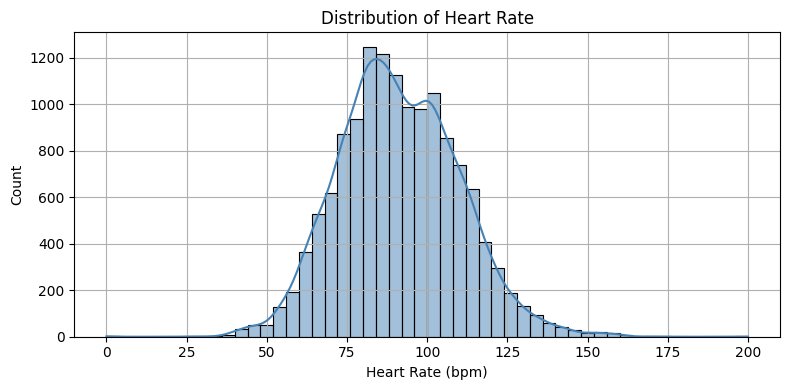

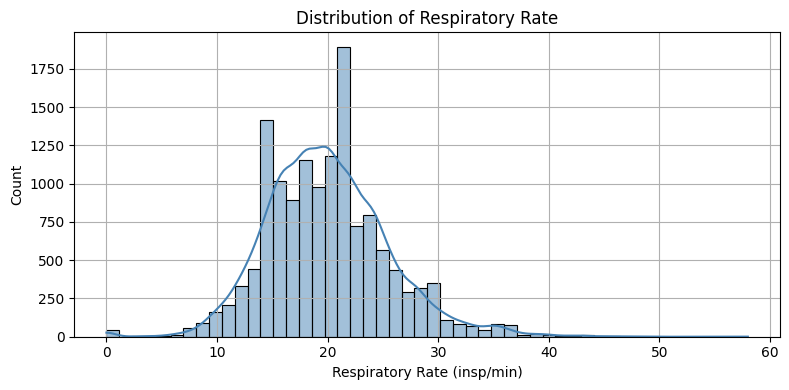

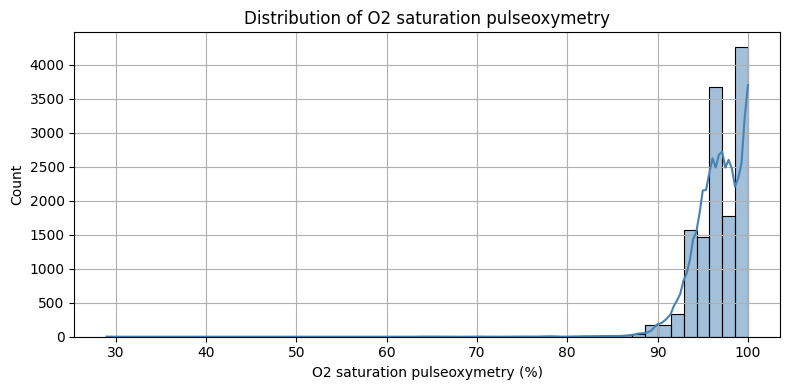

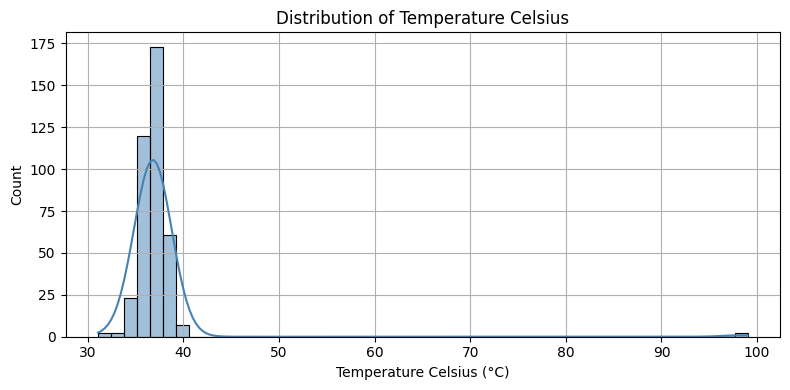

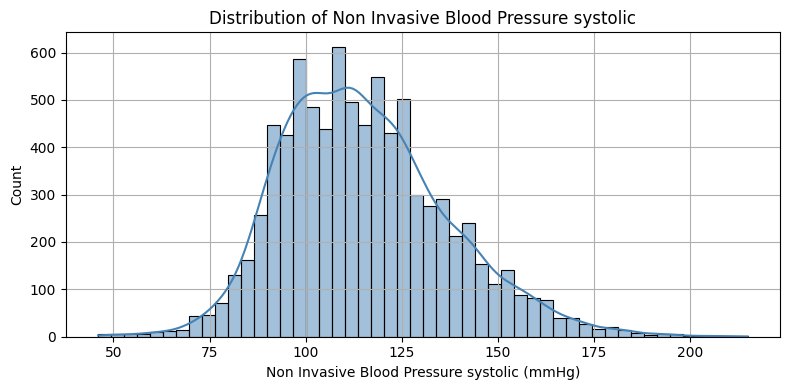

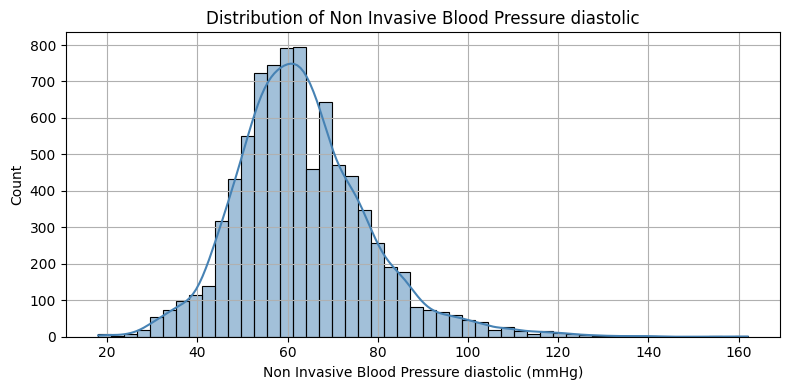

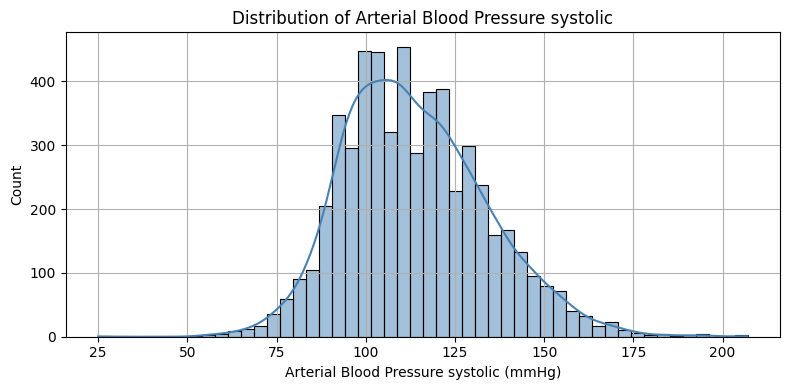

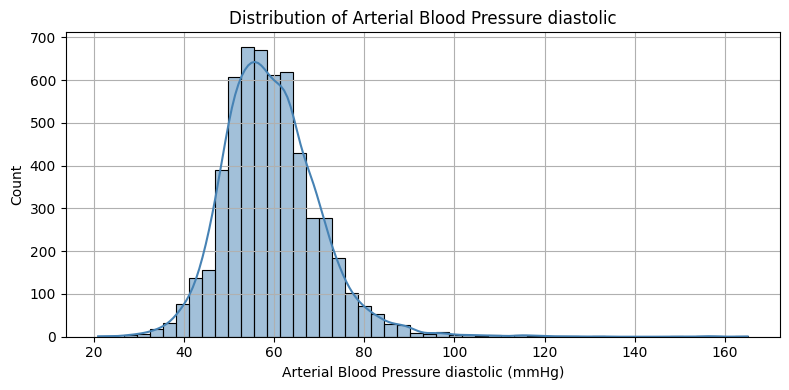

In [77]:
# Plot distributions
for vital in core_vitals:
    subset = df_chartevents[df_chartevents['label'] == vital]
    if subset.empty:
        print(f"⚠️ No data found for {vital}")
        continue
    plt.figure(figsize=(8,4))
    sns.histplot(subset['valuenum'], bins=50, kde=True, color="steelblue")
    unit = subset['valueuom'].dropna().unique()
    plt.title(f"Distribution of {vital}")
    plt.xlabel(f"{vital} ({unit[0] if len(unit) > 0 else 'unknown'})")
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

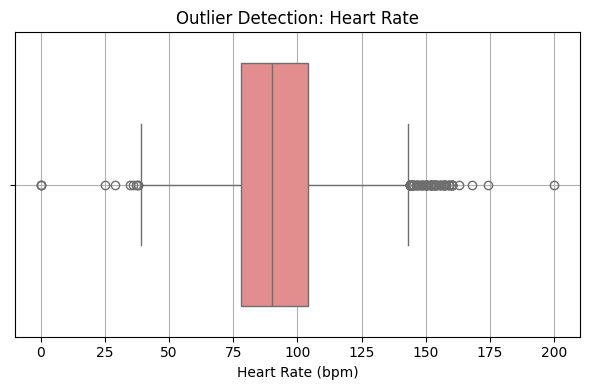

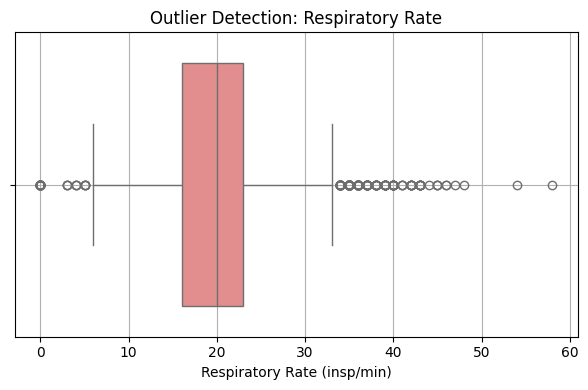

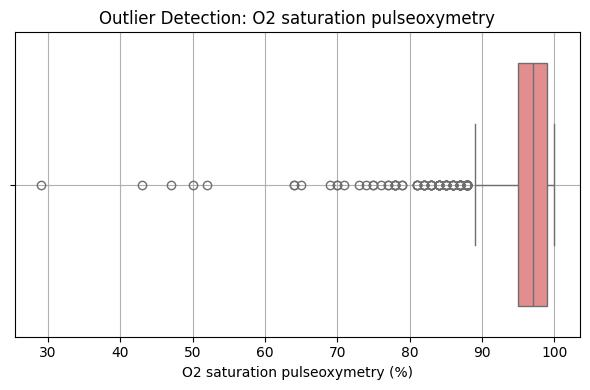

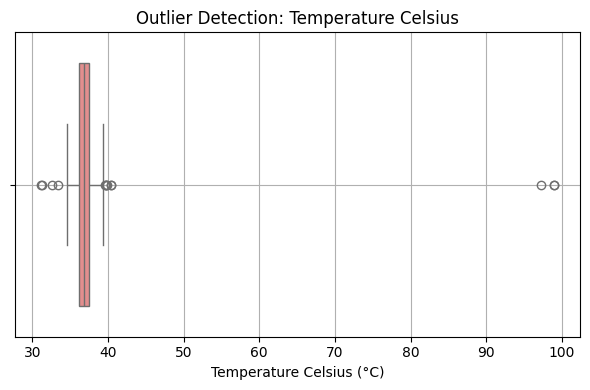

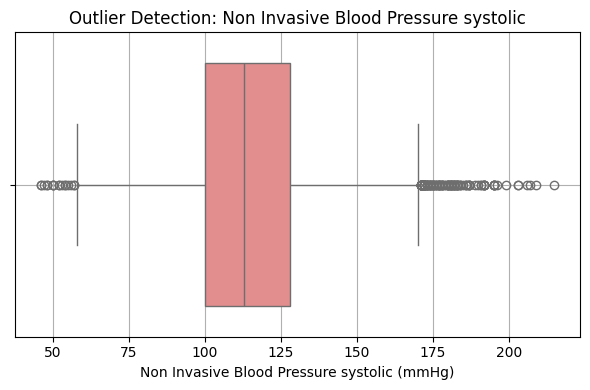

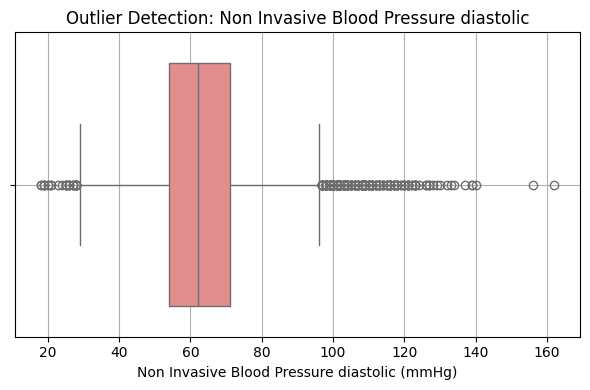

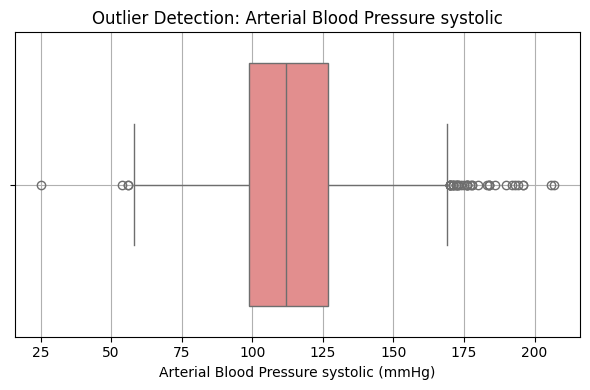

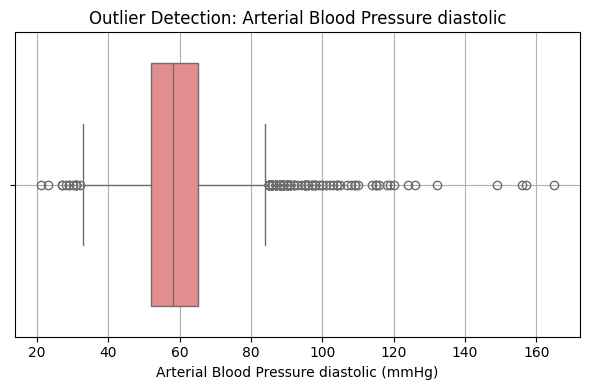

In [80]:
# Plot boxplots for outlier detection
for vital in core_vitals:
    subset = df_chartevents[df_chartevents['label'] == vital]
    if subset.empty:
        print(f"⚠️ No data found for {vital}")
        continue
    plt.figure(figsize=(6,4))
    sns.boxplot(x=subset['valuenum'], color="lightcoral")
    unit = subset['valueuom'].dropna().unique()
    plt.title(f"Outlier Detection: {vital}")
    plt.xlabel(f"{vital} ({unit[0] if len(unit) > 0 else 'unknown'})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [79]:
for vital in core_vitals:
    subset = df_chartevents[df_chartevents['label'] == vital]['valuenum'].dropna()
    if subset.empty:
        continue
    Q1 = subset.quantile(0.25)
    Q3 = subset.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = subset[(subset < lower_bound) | (subset > upper_bound)]
    print(f"{vital}: {len(outliers)} potential outliers flagged (IQR method)")

Heart Rate: 94 potential outliers flagged (IQR method)
Respiratory Rate: 328 potential outliers flagged (IQR method)
O2 saturation pulseoxymetry: 111 potential outliers flagged (IQR method)
Temperature Celsius: 13 potential outliers flagged (IQR method)
Non Invasive Blood Pressure systolic: 135 potential outliers flagged (IQR method)
Non Invasive Blood Pressure diastolic: 283 potential outliers flagged (IQR method)
Arterial Blood Pressure systolic: 43 potential outliers flagged (IQR method)
Arterial Blood Pressure diastolic: 128 potential outliers flagged (IQR method)


### Barplot – Most Frequent Vital Measurements

/tmp/ipython-input-2676062093.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vital_counts.values, y=vital_counts.index, palette="viridis")


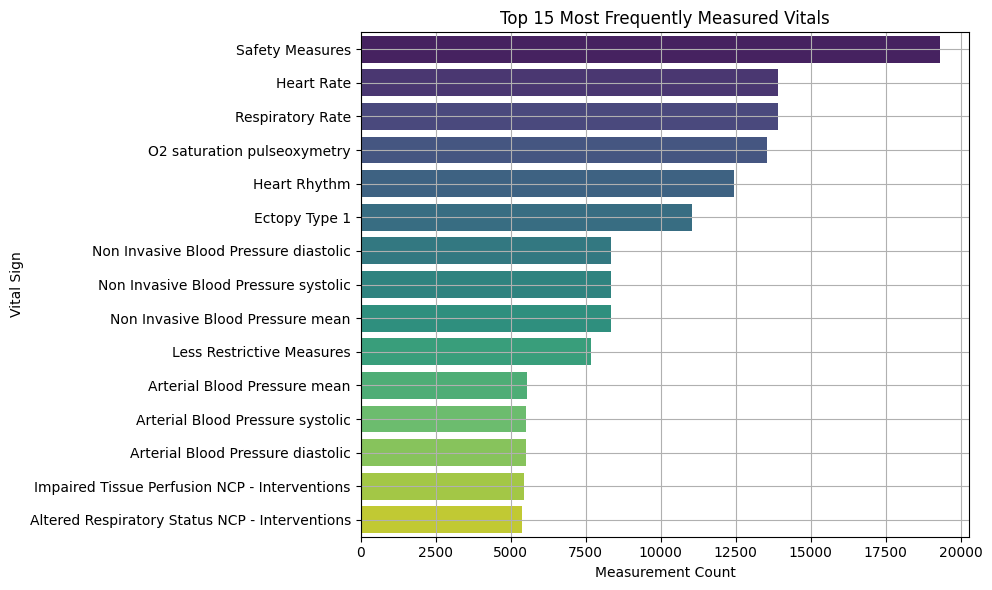

In [81]:
# Count measurements per label
vital_counts = df_chartevents['label'].value_counts().head(15)

# Plot barplot
plt.figure(figsize=(10,6))
sns.barplot(x=vital_counts.values, y=vital_counts.index, palette="viridis")
plt.title("Top 15 Most Frequently Measured Vitals")
plt.xlabel("Measurement Count")
plt.ylabel("Vital Sign")
plt.grid(True)
plt.tight_layout()
plt.show()

### Sample Time-Series Plot (Heart Rate)

In [82]:
# Pick one admission (replace with a real hadm_id from your dataset)
sample_hadm = df_chartevents['hadm_id'].dropna().unique()[0]

In [83]:
# Filter for Heart Rate in that admission
hr_data = df_chartevents[
    (df_chartevents['hadm_id'] == sample_hadm) &
    (df_chartevents['label'] == "Heart Rate")
].copy()

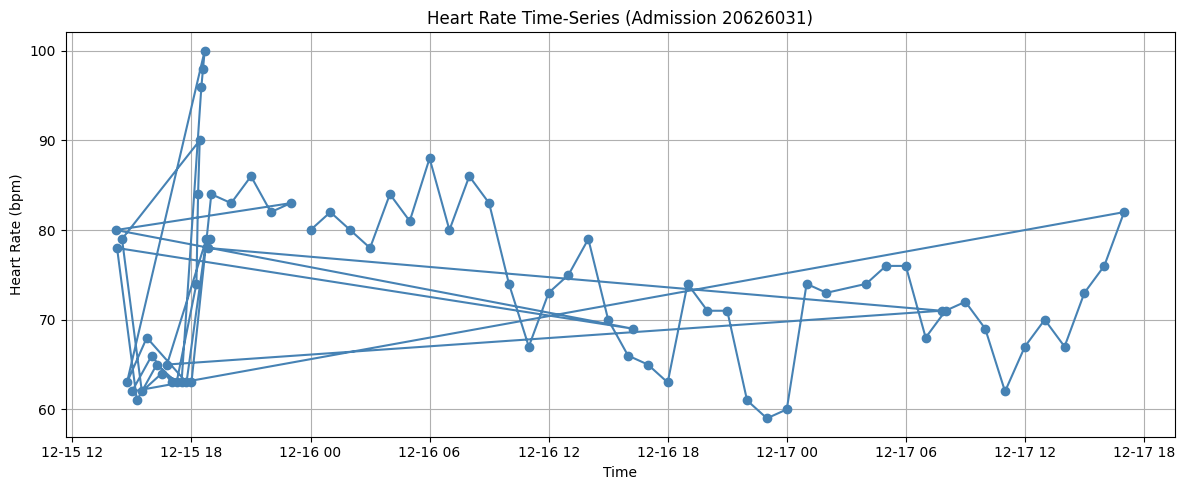

In [84]:
# Convert charttime to datetime
hr_data['charttime'] = pd.to_datetime(hr_data['charttime'], errors='coerce')

# Plot Heart Rate vs time
plt.figure(figsize=(12,5))
plt.plot(hr_data['charttime'], hr_data['valuenum'], marker='o', linestyle='-', color='steelblue')
plt.title(f"Heart Rate Time-Series (Admission {sample_hadm})")
plt.xlabel("Time")
plt.ylabel("Heart Rate (bpm)")
plt.grid(True)
plt.tight_layout()
plt.show()